In [15]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from master_function import data_preprocessing, mass_import
from master_function import plot_train_test_values
from master_function import calculate_accuracy, model_bias
from sklearn.metrics import mean_squared_error

In [16]:
import pandas_datareader as pdr
# Set the start and end dates for the data
start_date = '2020-01-01'
end_date   = '2023-06-01'

#GBPUSD price data
data = np.array((pdr.get_data_fred('SP500', start = start_date, end = end_date)).dropna())
# Difference the data and make it stationary
data = np.diff(data[:, 0])

In [24]:
from fracdiff.sklearn import Fracdiff
from statsmodels.tsa.stattools import adfuller
#Calculate the fractional differentiation
window = 50
f = Fracdiff(0.4, mode = 'valid', window = window)
#frac_df = f.fit_transform(data)
# Calculate a simple differencing function for comparison
#diff_df = np.reshape(np.diff(data[:, 0]), (-1, 1))
# Harmonizing time indices
df = data[window - 1:, ]
#diff_df = diff_df[window - 2:, ]
print('p-value: %f' % adfuller(data)[1])
#print('p-value: %f' % adfuller(frac_df)[1])
#print('p-value: %f' % adfuller(diff_df)[1])
#исх данные не стационарны, данные после дифференцирования и фракционного дифференцировнаия- стационарны; frac_diff(сохраняют память)

p-value: 0.000000


In [17]:
#tuning params
num_lags = 15
train_test_split = 0.80

In [18]:
#train test split
x_train, y_train, x_test, y_test = data_preprocessing(data, num_lags, train_test_split)

In [19]:
#модель-пример 
model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression()

In [20]:
# continuous retraining loop
# Store the new forecasts
y_predicted = []
# Reshape x_test to forecast one period
#3 d - latest_values = np.transpose(np.reshape(x_test[0], (-1, 1)))
latest_values = x_test[0].reshape(1, -1)
# Isolate the real values for comparison
y_test_store = y_test
y_train_store = y_train
for i in range(len(y_test)):
    try:
        predicted_value = model.predict(latest_values)
        y_predicted = np.append(y_predicted, predicted_value)
        x_train = np.concatenate((x_train, latest_values), axis = 0)
        y_train = np.append(y_train, y_test[0])
        y_test = y_test[1:]
        x_test = x_test[1:, ]
        model.fit(x_train, y_train)
        latest_values = np.transpose(np.reshape(x_test[0], (-1, 1)))
    except IndexError:
        pass

In [21]:
#предсказания IS 
y_predicted_train = np.reshape(model.predict(x_train), (-1, 1))

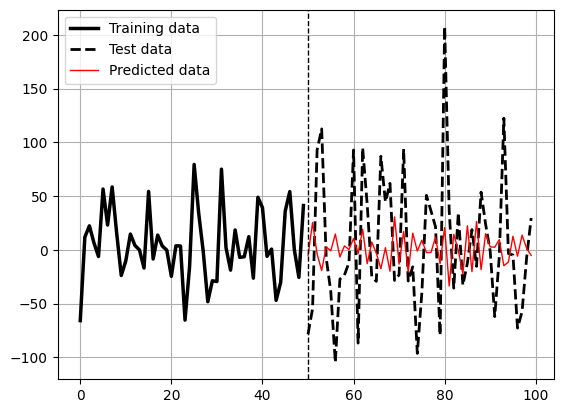

In [22]:
plot_train_test_values(100, 50, y_train, y_test_store, y_predicted)
#т к пример- линеная регрессия то очевиден poor fit; но 
#update the model every once in a while due to changing market dynamics